<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[11:07:09] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


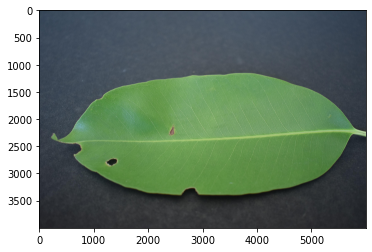

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

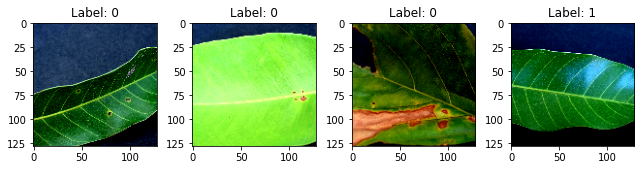

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[11:07:17] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[11:07:19] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2512291376243345 samples/sec                   batch loss = 0.49886012077331543 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.256541466008583 samples/sec                   batch loss = 0.5398350954055786 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2628771806217804 samples/sec                   batch loss = 1.9912421703338623 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2640695145649794 samples/sec                   batch loss = 1.376979947090149 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2686342481618387 samples/sec                   batch loss = 0.6117005348205566 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.2515679646292066 samples/sec                   batch loss = 0.4590415954589844 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.259664328592991 samples/sec                   batch loss = 0.5166675448417664 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.273977977481778 samples/sec                   batch loss = 0.19996991753578186 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2712321526289396 samples/sec                   batch loss = 0.4902591407299042 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2658104304092386 samples/sec                   batch loss = 0.5783138871192932 | accuracy = 0.585


Epoch[1] Batch[55] Speed: 1.2666830703422476 samples/sec                   batch loss = 0.7401674389839172 | accuracy = 0.5863636363636363


Epoch[1] Batch[60] Speed: 1.265230991991071 samples/sec                   batch loss = 0.6249501705169678 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.2710438691237895 samples/sec                   batch loss = 0.6165004968643188 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.275215024920985 samples/sec                   batch loss = 0.47644856572151184 | accuracy = 0.5928571428571429


Epoch[1] Batch[75] Speed: 1.2699440798825947 samples/sec                   batch loss = 0.4984639883041382 | accuracy = 0.6


Epoch[1] Batch[80] Speed: 1.2682587946382304 samples/sec                   batch loss = 0.5888549089431763 | accuracy = 0.6


Epoch[1] Batch[85] Speed: 1.2702769617867873 samples/sec                   batch loss = 0.73011314868927 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.2711619370661336 samples/sec                   batch loss = 0.9743654727935791 | accuracy = 0.5916666666666667


Epoch[1] Batch[95] Speed: 1.2690520635200149 samples/sec                   batch loss = 0.5204998850822449 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2692293871275304 samples/sec                   batch loss = 0.6026164889335632 | accuracy = 0.59


Epoch[1] Batch[105] Speed: 1.2637506343340892 samples/sec                   batch loss = 0.40485864877700806 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.269031617367802 samples/sec                   batch loss = 0.5833116769790649 | accuracy = 0.6090909090909091


Epoch[1] Batch[115] Speed: 1.266132453242867 samples/sec                   batch loss = 0.8409430980682373 | accuracy = 0.6152173913043478


Epoch[1] Batch[120] Speed: 1.2741884207026333 samples/sec                   batch loss = 0.5386015772819519 | accuracy = 0.6104166666666667


Epoch[1] Batch[125] Speed: 1.2670570172093083 samples/sec                   batch loss = 0.9220075011253357 | accuracy = 0.608


Epoch[1] Batch[130] Speed: 1.2597246721976105 samples/sec                   batch loss = 0.6045152544975281 | accuracy = 0.6076923076923076


Epoch[1] Batch[135] Speed: 1.265325842286484 samples/sec                   batch loss = 0.4223991334438324 | accuracy = 0.6129629629629629


Epoch[1] Batch[140] Speed: 1.2689160561988628 samples/sec                   batch loss = 0.3348050117492676 | accuracy = 0.6160714285714286


Epoch[1] Batch[145] Speed: 1.2753324149112162 samples/sec                   batch loss = 0.3678290545940399 | accuracy = 0.6155172413793103


Epoch[1] Batch[150] Speed: 1.2686270534771178 samples/sec                   batch loss = 0.6392645239830017 | accuracy = 0.6183333333333333


Epoch[1] Batch[155] Speed: 1.2703122601916128 samples/sec                   batch loss = 0.7416589260101318 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.2693735290641712 samples/sec                   batch loss = 0.4553372859954834 | accuracy = 0.625


Epoch[1] Batch[165] Speed: 1.272180388413048 samples/sec                   batch loss = 0.42875757813453674 | accuracy = 0.6242424242424243


Epoch[1] Batch[170] Speed: 1.2698185492996144 samples/sec                   batch loss = 0.20669259130954742 | accuracy = 0.6294117647058823


Epoch[1] Batch[175] Speed: 1.2652316599011795 samples/sec                   batch loss = 0.6871200203895569 | accuracy = 0.6285714285714286


Epoch[1] Batch[180] Speed: 1.2667954512231512 samples/sec                   batch loss = 0.57892906665802 | accuracy = 0.6291666666666667


Epoch[1] Batch[185] Speed: 1.2727039357200618 samples/sec                   batch loss = 0.6178096532821655 | accuracy = 0.6297297297297297


Epoch[1] Batch[190] Speed: 1.2738826961774596 samples/sec                   batch loss = 0.8701473474502563 | accuracy = 0.6289473684210526


Epoch[1] Batch[195] Speed: 1.2754424573568144 samples/sec                   batch loss = 0.6263003945350647 | accuracy = 0.6282051282051282


Epoch[1] Batch[200] Speed: 1.2623368950734433 samples/sec                   batch loss = 0.4959842562675476 | accuracy = 0.62875


Epoch[1] Batch[205] Speed: 1.2778696647609946 samples/sec                   batch loss = 0.4613693952560425 | accuracy = 0.6304878048780488


Epoch[1] Batch[210] Speed: 1.2653882565758312 samples/sec                   batch loss = 0.6943420767784119 | accuracy = 0.6333333333333333


Epoch[1] Batch[215] Speed: 1.2708292650706503 samples/sec                   batch loss = 0.774328351020813 | accuracy = 0.6337209302325582


Epoch[1] Batch[220] Speed: 1.2636965672893377 samples/sec                   batch loss = 0.5717862248420715 | accuracy = 0.634090909090909


Epoch[1] Batch[225] Speed: 1.2634157405853883 samples/sec                   batch loss = 0.4587495028972626 | accuracy = 0.6366666666666667


Epoch[1] Batch[230] Speed: 1.2704921490169583 samples/sec                   batch loss = 1.1621977090835571 | accuracy = 0.6358695652173914


Epoch[1] Batch[235] Speed: 1.269421359538296 samples/sec                   batch loss = 0.4868415892124176 | accuracy = 0.6382978723404256


Epoch[1] Batch[240] Speed: 1.270172328451721 samples/sec                   batch loss = 0.7559575438499451 | accuracy = 0.6333333333333333


Epoch[1] Batch[245] Speed: 1.2669908979766393 samples/sec                   batch loss = 0.5540435314178467 | accuracy = 0.6336734693877552


Epoch[1] Batch[250] Speed: 1.266936648999105 samples/sec                   batch loss = 0.5037781596183777 | accuracy = 0.636


Epoch[1] Batch[255] Speed: 1.2699065911216831 samples/sec                   batch loss = 0.7709997296333313 | accuracy = 0.634313725490196


Epoch[1] Batch[260] Speed: 1.2680186784901695 samples/sec                   batch loss = 0.7871224880218506 | accuracy = 0.6365384615384615


Epoch[1] Batch[265] Speed: 1.2784070629766437 samples/sec                   batch loss = 0.7756040096282959 | accuracy = 0.6367924528301887


Epoch[1] Batch[270] Speed: 1.267400067656249 samples/sec                   batch loss = 0.453012079000473 | accuracy = 0.6361111111111111


Epoch[1] Batch[275] Speed: 1.2752255901044316 samples/sec                   batch loss = 1.3382920026779175 | accuracy = 0.6318181818181818


Epoch[1] Batch[280] Speed: 1.2733806975974955 samples/sec                   batch loss = 0.45385825634002686 | accuracy = 0.6330357142857143


Epoch[1] Batch[285] Speed: 1.2707889326063335 samples/sec                   batch loss = 0.4918588399887085 | accuracy = 0.6350877192982456


Epoch[1] Batch[290] Speed: 1.2710610097641715 samples/sec                   batch loss = 0.2869027853012085 | accuracy = 0.6396551724137931


Epoch[1] Batch[295] Speed: 1.266453875161579 samples/sec                   batch loss = 0.3636966049671173 | accuracy = 0.6415254237288136


Epoch[1] Batch[300] Speed: 1.2765681129002178 samples/sec                   batch loss = 0.6830422878265381 | accuracy = 0.6383333333333333


Epoch[1] Batch[305] Speed: 1.2664374321384877 samples/sec                   batch loss = 0.5088251829147339 | accuracy = 0.639344262295082


Epoch[1] Batch[310] Speed: 1.2727280727107766 samples/sec                   batch loss = 0.23219294846057892 | accuracy = 0.6427419354838709


Epoch[1] Batch[315] Speed: 1.2727632178062267 samples/sec                   batch loss = 0.26610836386680603 | accuracy = 0.6460317460317461


Epoch[1] Batch[320] Speed: 1.2713008346133698 samples/sec                   batch loss = 0.461802214384079 | accuracy = 0.64765625


Epoch[1] Batch[325] Speed: 1.2750415483244937 samples/sec                   batch loss = 0.5843272805213928 | accuracy = 0.6492307692307693


Epoch[1] Batch[330] Speed: 1.2709077233788333 samples/sec                   batch loss = 0.5488517880439758 | accuracy = 0.6492424242424243


Epoch[1] Batch[335] Speed: 1.2733287026467774 samples/sec                   batch loss = 0.3258059620857239 | accuracy = 0.65


Epoch[1] Batch[340] Speed: 1.2732846359015957 samples/sec                   batch loss = 1.02339506149292 | accuracy = 0.6522058823529412


Epoch[1] Batch[345] Speed: 1.2627704361525987 samples/sec                   batch loss = 0.6701551079750061 | accuracy = 0.6536231884057971


Epoch[1] Batch[350] Speed: 1.2692133520403153 samples/sec                   batch loss = 0.5384722948074341 | accuracy = 0.6557142857142857


Epoch[1] Batch[355] Speed: 1.2734508685191999 samples/sec                   batch loss = 0.4154740571975708 | accuracy = 0.6549295774647887


Epoch[1] Batch[360] Speed: 1.2709815696787716 samples/sec                   batch loss = 0.35752061009407043 | accuracy = 0.65625


Epoch[1] Batch[365] Speed: 1.271084314072958 samples/sec                   batch loss = 0.7780357599258423 | accuracy = 0.6568493150684932


Epoch[1] Batch[370] Speed: 1.2750054052328734 samples/sec                   batch loss = 0.33725783228874207 | accuracy = 0.6594594594594595


Epoch[1] Batch[375] Speed: 1.2744056129335806 samples/sec                   batch loss = 0.5288327932357788 | accuracy = 0.6593333333333333


Epoch[1] Batch[380] Speed: 1.277442133423485 samples/sec                   batch loss = 0.982246994972229 | accuracy = 0.6578947368421053


Epoch[1] Batch[385] Speed: 1.2747576912632392 samples/sec                   batch loss = 0.5304596424102783 | accuracy = 0.6571428571428571


Epoch[1] Batch[390] Speed: 1.2702923504959278 samples/sec                   batch loss = 0.11923528462648392 | accuracy = 0.6576923076923077


Epoch[1] Batch[395] Speed: 1.2734069866236684 samples/sec                   batch loss = 0.20431220531463623 | accuracy = 0.6575949367088607


Epoch[1] Batch[400] Speed: 1.2671626692052393 samples/sec                   batch loss = 0.34852758049964905 | accuracy = 0.65875


Epoch[1] Batch[405] Speed: 1.2749615130270557 samples/sec                   batch loss = 0.3557388186454773 | accuracy = 0.6580246913580247


Epoch[1] Batch[410] Speed: 1.2796056879140103 samples/sec                   batch loss = 0.5886369347572327 | accuracy = 0.6591463414634147


Epoch[1] Batch[415] Speed: 1.2672311035856885 samples/sec                   batch loss = 0.2493237406015396 | accuracy = 0.6608433734939759


Epoch[1] Batch[420] Speed: 1.277114527160086 samples/sec                   batch loss = 0.3207029700279236 | accuracy = 0.6613095238095238


Epoch[1] Batch[425] Speed: 1.2735864962247228 samples/sec                   batch loss = 0.5665528178215027 | accuracy = 0.6611764705882353


Epoch[1] Batch[430] Speed: 1.27307748576618 samples/sec                   batch loss = 0.3526098430156708 | accuracy = 0.6633720930232558


Epoch[1] Batch[435] Speed: 1.2691316466008975 samples/sec                   batch loss = 0.765304446220398 | accuracy = 0.6632183908045977


Epoch[1] Batch[440] Speed: 1.2674591439121383 samples/sec                   batch loss = 0.4374978244304657 | accuracy = 0.6647727272727273


Epoch[1] Batch[445] Speed: 1.270582978557437 samples/sec                   batch loss = 0.16382405161857605 | accuracy = 0.6640449438202247


Epoch[1] Batch[450] Speed: 1.2725679167587307 samples/sec                   batch loss = 0.29015132784843445 | accuracy = 0.6633333333333333


Epoch[1] Batch[455] Speed: 1.2792635099452174 samples/sec                   batch loss = 0.38047605752944946 | accuracy = 0.6631868131868132


Epoch[1] Batch[460] Speed: 1.2697669409379413 samples/sec                   batch loss = 0.3244865834712982 | accuracy = 0.6641304347826087


Epoch[1] Batch[465] Speed: 1.272134182534081 samples/sec                   batch loss = 0.5301862359046936 | accuracy = 0.6650537634408602


Epoch[1] Batch[470] Speed: 1.2764143694242704 samples/sec                   batch loss = 0.5502590537071228 | accuracy = 0.6664893617021277


Epoch[1] Batch[475] Speed: 1.2758594335384807 samples/sec                   batch loss = 1.3203095197677612 | accuracy = 0.6663157894736842


Epoch[1] Batch[480] Speed: 1.2719794799758117 samples/sec                   batch loss = 0.5887201428413391 | accuracy = 0.6640625


Epoch[1] Batch[485] Speed: 1.2630156996769968 samples/sec                   batch loss = 0.42268019914627075 | accuracy = 0.6644329896907216


Epoch[1] Batch[490] Speed: 1.2709730966557407 samples/sec                   batch loss = 0.615899384021759 | accuracy = 0.6653061224489796


Epoch[1] Batch[495] Speed: 1.2682435510301766 samples/sec                   batch loss = 0.18263429403305054 | accuracy = 0.6666666666666666


Epoch[1] Batch[500] Speed: 1.2686979486635022 samples/sec                   batch loss = 0.5840800404548645 | accuracy = 0.6655


Epoch[1] Batch[505] Speed: 1.267646845706539 samples/sec                   batch loss = 0.6882742047309875 | accuracy = 0.6653465346534654


Epoch[1] Batch[510] Speed: 1.26607961536186 samples/sec                   batch loss = 0.17460162937641144 | accuracy = 0.6656862745098039


Epoch[1] Batch[515] Speed: 1.2698608386075112 samples/sec                   batch loss = 0.49202555418014526 | accuracy = 0.666504854368932


Epoch[1] Batch[520] Speed: 1.2703997933099702 samples/sec                   batch loss = 0.6269895434379578 | accuracy = 0.6663461538461538


Epoch[1] Batch[525] Speed: 1.2723784654177188 samples/sec                   batch loss = 0.41489648818969727 | accuracy = 0.6676190476190477


Epoch[1] Batch[530] Speed: 1.2707040406535228 samples/sec                   batch loss = 0.24034510552883148 | accuracy = 0.6674528301886793


Epoch[1] Batch[535] Speed: 1.2700902110516488 samples/sec                   batch loss = 0.3875100314617157 | accuracy = 0.6682242990654206


Epoch[1] Batch[540] Speed: 1.2684451030499146 samples/sec                   batch loss = 0.7508922219276428 | accuracy = 0.6680555555555555


Epoch[1] Batch[545] Speed: 1.2687753764097334 samples/sec                   batch loss = 0.3526875674724579 | accuracy = 0.6692660550458716


Epoch[1] Batch[550] Speed: 1.2753627595219956 samples/sec                   batch loss = 1.2619725465774536 | accuracy = 0.6686363636363636


Epoch[1] Batch[555] Speed: 1.2674178761259831 samples/sec                   batch loss = 0.6428595781326294 | accuracy = 0.6666666666666666


Epoch[1] Batch[560] Speed: 1.2670651510213915 samples/sec                   batch loss = 1.9680274724960327 | accuracy = 0.6669642857142857


Epoch[1] Batch[565] Speed: 1.273933865786337 samples/sec                   batch loss = 0.32369059324264526 | accuracy = 0.6676991150442478


Epoch[1] Batch[570] Speed: 1.2724548954411554 samples/sec                   batch loss = 1.3253852128982544 | accuracy = 0.6671052631578948


Epoch[1] Batch[575] Speed: 1.2716130313910883 samples/sec                   batch loss = 1.1179702281951904 | accuracy = 0.6678260869565218


Epoch[1] Batch[580] Speed: 1.2617805595037657 samples/sec                   batch loss = 0.5581607222557068 | accuracy = 0.6685344827586207


Epoch[1] Batch[585] Speed: 1.2676479950724284 samples/sec                   batch loss = 0.5498956441879272 | accuracy = 0.6683760683760683


Epoch[1] Batch[590] Speed: 1.2717866367168573 samples/sec                   batch loss = 0.5479884743690491 | accuracy = 0.6690677966101695


Epoch[1] Batch[595] Speed: 1.27182221189906 samples/sec                   batch loss = 0.28289535641670227 | accuracy = 0.6697478991596638


Epoch[1] Batch[600] Speed: 1.2698189337351815 samples/sec                   batch loss = 0.3888663053512573 | accuracy = 0.6704166666666667


Epoch[1] Batch[605] Speed: 1.2614252741649266 samples/sec                   batch loss = 0.7712068557739258 | accuracy = 0.6706611570247933


Epoch[1] Batch[610] Speed: 1.267701442888167 samples/sec                   batch loss = 0.660953938961029 | accuracy = 0.6704918032786885


Epoch[1] Batch[615] Speed: 1.2668548537691373 samples/sec                   batch loss = 0.3569326400756836 | accuracy = 0.6711382113821138


Epoch[1] Batch[620] Speed: 1.2715412318292147 samples/sec                   batch loss = 0.9252750873565674 | accuracy = 0.6717741935483871


Epoch[1] Batch[625] Speed: 1.2653808123463737 samples/sec                   batch loss = 0.8527674078941345 | accuracy = 0.672


Epoch[1] Batch[630] Speed: 1.2683797018918928 samples/sec                   batch loss = 0.7776545882225037 | accuracy = 0.6718253968253968


Epoch[1] Batch[635] Speed: 1.267891707708058 samples/sec                   batch loss = 0.5478989481925964 | accuracy = 0.6728346456692913


Epoch[1] Batch[640] Speed: 1.271000634393651 samples/sec                   batch loss = 0.5087241530418396 | accuracy = 0.6734375


Epoch[1] Batch[645] Speed: 1.2747666022592492 samples/sec                   batch loss = 0.6306485533714294 | accuracy = 0.6736434108527132


Epoch[1] Batch[650] Speed: 1.2657872235827377 samples/sec                   batch loss = 0.7813112735748291 | accuracy = 0.6730769230769231


Epoch[1] Batch[655] Speed: 1.2660235336837384 samples/sec                   batch loss = 0.4718725383281708 | accuracy = 0.6740458015267176


Epoch[1] Batch[660] Speed: 1.2702423385544062 samples/sec                   batch loss = 0.9556726217269897 | accuracy = 0.6742424242424242


Epoch[1] Batch[665] Speed: 1.2699025540025222 samples/sec                   batch loss = 0.4022400975227356 | accuracy = 0.675187969924812


Epoch[1] Batch[670] Speed: 1.2769627902994092 samples/sec                   batch loss = 0.4727955758571625 | accuracy = 0.6746268656716418


Epoch[1] Batch[675] Speed: 1.270861994966309 samples/sec                   batch loss = 0.9091002345085144 | accuracy = 0.6748148148148149


Epoch[1] Batch[680] Speed: 1.270542661724208 samples/sec                   batch loss = 0.26632747054100037 | accuracy = 0.6761029411764706


Epoch[1] Batch[685] Speed: 1.271175902506602 samples/sec                   batch loss = 0.3749020993709564 | accuracy = 0.677007299270073


Epoch[1] Batch[690] Speed: 1.2720576945837667 samples/sec                   batch loss = 0.5742948055267334 | accuracy = 0.6764492753623188


Epoch[1] Batch[695] Speed: 1.275441196851251 samples/sec                   batch loss = 1.30080246925354 | accuracy = 0.6773381294964029


Epoch[1] Batch[700] Speed: 1.2674690064491485 samples/sec                   batch loss = 0.6871952414512634 | accuracy = 0.6782142857142858


Epoch[1] Batch[705] Speed: 1.2670782610324338 samples/sec                   batch loss = 0.49260255694389343 | accuracy = 0.6787234042553192


Epoch[1] Batch[710] Speed: 1.2683226492051596 samples/sec                   batch loss = 0.8172988295555115 | accuracy = 0.6792253521126761


Epoch[1] Batch[715] Speed: 1.2702533985484756 samples/sec                   batch loss = 0.3849217891693115 | accuracy = 0.6800699300699301


Epoch[1] Batch[720] Speed: 1.2627840277226337 samples/sec                   batch loss = 0.3359362781047821 | accuracy = 0.6805555555555556


Epoch[1] Batch[725] Speed: 1.2672466100248891 samples/sec                   batch loss = 0.5382955074310303 | accuracy = 0.6793103448275862


Epoch[1] Batch[730] Speed: 1.2662291589416763 samples/sec                   batch loss = 0.33914950489997864 | accuracy = 0.6794520547945205


Epoch[1] Batch[735] Speed: 1.2657233375797678 samples/sec                   batch loss = 0.38653600215911865 | accuracy = 0.6802721088435374


Epoch[1] Batch[740] Speed: 1.2750426142376583 samples/sec                   batch loss = 0.4903098940849304 | accuracy = 0.6807432432432432


Epoch[1] Batch[745] Speed: 1.264099992284546 samples/sec                   batch loss = 0.35334691405296326 | accuracy = 0.6805369127516778


Epoch[1] Batch[750] Speed: 1.2720514254874973 samples/sec                   batch loss = 0.27235981822013855 | accuracy = 0.6806666666666666


Epoch[1] Batch[755] Speed: 1.2783605010968446 samples/sec                   batch loss = 0.7768417000770569 | accuracy = 0.6801324503311258


Epoch[1] Batch[760] Speed: 1.2734238044376545 samples/sec                   batch loss = 0.8359677791595459 | accuracy = 0.6796052631578947


Epoch[1] Batch[765] Speed: 1.2747949826745761 samples/sec                   batch loss = 0.3362971544265747 | accuracy = 0.6797385620915033


Epoch[1] Batch[770] Speed: 1.2615041880918605 samples/sec                   batch loss = 0.5071996450424194 | accuracy = 0.6798701298701298


Epoch[1] Batch[775] Speed: 1.271752413148888 samples/sec                   batch loss = 0.5667360424995422 | accuracy = 0.6803225806451613


Epoch[1] Batch[780] Speed: 1.2697100516648865 samples/sec                   batch loss = 0.48757249116897583 | accuracy = 0.6810897435897436


Epoch[1] Batch[785] Speed: 1.267179035356612 samples/sec                   batch loss = 0.6728395819664001 | accuracy = 0.6815286624203821


[Epoch 1] training: accuracy=0.6824238578680203
[Epoch 1] time cost: 647.2152802944183
[Epoch 1] validation: validation accuracy=0.7322222222222222


Epoch[2] Batch[5] Speed: 1.2613023702135293 samples/sec                   batch loss = 0.3970179855823517 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2637521574164319 samples/sec                   batch loss = 0.21802392601966858 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2727521140635818 samples/sec                   batch loss = 0.32953301072120667 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.27129765562 samples/sec                   batch loss = 0.6558987498283386 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2781247240777025 samples/sec                   batch loss = 0.4073435664176941 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2655555839686488 samples/sec                   batch loss = 0.28367769718170166 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2674743686696035 samples/sec                   batch loss = 0.5288681387901306 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2723320521700237 samples/sec                   batch loss = 0.17252853512763977 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.273093811851192 samples/sec                   batch loss = 0.31174778938293457 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2661195538957597 samples/sec                   batch loss = 1.6975765228271484 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2636517370336706 samples/sec                   batch loss = 0.49640318751335144 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2657560914812174 samples/sec                   batch loss = 0.3798268735408783 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.270693838982737 samples/sec                   batch loss = 0.8016673922538757 | accuracy = 0.7269230769230769


Epoch[2] Batch[70] Speed: 1.2620093002501644 samples/sec                   batch loss = 0.5868471264839172 | accuracy = 0.7214285714285714


Epoch[2] Batch[75] Speed: 1.2600162567567192 samples/sec                   batch loss = 0.347802072763443 | accuracy = 0.7166666666666667


Epoch[2] Batch[80] Speed: 1.262117340269962 samples/sec                   batch loss = 0.688156008720398 | accuracy = 0.71875


Epoch[2] Batch[85] Speed: 1.271263169380357 samples/sec                   batch loss = 0.4034591615200043 | accuracy = 0.7029411764705882


Epoch[2] Batch[90] Speed: 1.273078548398026 samples/sec                   batch loss = 0.48566681146621704 | accuracy = 0.7111111111111111


Epoch[2] Batch[95] Speed: 1.2699491746799147 samples/sec                   batch loss = 0.4430606961250305 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.2677278811081962 samples/sec                   batch loss = 0.406772255897522 | accuracy = 0.71


Epoch[2] Batch[105] Speed: 1.2696767084639735 samples/sec                   batch loss = 0.36157891154289246 | accuracy = 0.7119047619047619


Epoch[2] Batch[110] Speed: 1.2734247709921869 samples/sec                   batch loss = 0.4109501838684082 | accuracy = 0.7181818181818181


Epoch[2] Batch[115] Speed: 1.2699783023249758 samples/sec                   batch loss = 0.9021298885345459 | accuracy = 0.7195652173913043


Epoch[2] Batch[120] Speed: 1.2725878978502136 samples/sec                   batch loss = 0.5244771242141724 | accuracy = 0.71875


Epoch[2] Batch[125] Speed: 1.2615760918279015 samples/sec                   batch loss = 0.3744445741176605 | accuracy = 0.724


Epoch[2] Batch[130] Speed: 1.2729789585213147 samples/sec                   batch loss = 0.6757752895355225 | accuracy = 0.7192307692307692


Epoch[2] Batch[135] Speed: 1.2714728129463777 samples/sec                   batch loss = 1.1348291635513306 | accuracy = 0.7074074074074074


Epoch[2] Batch[140] Speed: 1.2665149666442888 samples/sec                   batch loss = 0.9001203775405884 | accuracy = 0.7089285714285715


Epoch[2] Batch[145] Speed: 1.2688215305283137 samples/sec                   batch loss = 0.23736079037189484 | accuracy = 0.7086206896551724


Epoch[2] Batch[150] Speed: 1.2592115577275431 samples/sec                   batch loss = 0.3825189471244812 | accuracy = 0.71


Epoch[2] Batch[155] Speed: 1.2592395332925226 samples/sec                   batch loss = 0.32460764050483704 | accuracy = 0.7096774193548387


Epoch[2] Batch[160] Speed: 1.2627884949459003 samples/sec                   batch loss = 0.5799583196640015 | accuracy = 0.7140625


Epoch[2] Batch[165] Speed: 1.2667259161899864 samples/sec                   batch loss = 0.5247121453285217 | accuracy = 0.7151515151515152


Epoch[2] Batch[170] Speed: 1.26354666966313 samples/sec                   batch loss = 0.5351741313934326 | accuracy = 0.7132352941176471


Epoch[2] Batch[175] Speed: 1.2655725769032697 samples/sec                   batch loss = 0.292073518037796 | accuracy = 0.7185714285714285


Epoch[2] Batch[180] Speed: 1.2680666944458154 samples/sec                   batch loss = 1.860135555267334 | accuracy = 0.7166666666666667


Epoch[2] Batch[185] Speed: 1.2723362977318093 samples/sec                   batch loss = 0.7172715663909912 | accuracy = 0.7135135135135136


Epoch[2] Batch[190] Speed: 1.2749677139500815 samples/sec                   batch loss = 0.33156493306159973 | accuracy = 0.7131578947368421


Epoch[2] Batch[195] Speed: 1.2666641349313263 samples/sec                   batch loss = 0.6256483197212219 | accuracy = 0.7102564102564103


Epoch[2] Batch[200] Speed: 1.2718156558893359 samples/sec                   batch loss = 1.0193533897399902 | accuracy = 0.715


Epoch[2] Batch[205] Speed: 1.2686473906632778 samples/sec                   batch loss = 0.8303834199905396 | accuracy = 0.7146341463414634


Epoch[2] Batch[210] Speed: 1.2666106789223657 samples/sec                   batch loss = 0.3776775002479553 | accuracy = 0.719047619047619


Epoch[2] Batch[215] Speed: 1.2676740479249726 samples/sec                   batch loss = 0.6766752004623413 | accuracy = 0.7186046511627907


Epoch[2] Batch[220] Speed: 1.2648459161277048 samples/sec                   batch loss = 0.39928871393203735 | accuracy = 0.7215909090909091


Epoch[2] Batch[225] Speed: 1.2691433593081884 samples/sec                   batch loss = 0.2594606280326843 | accuracy = 0.7255555555555555


Epoch[2] Batch[230] Speed: 1.2650123370479696 samples/sec                   batch loss = 0.4060012698173523 | accuracy = 0.725


Epoch[2] Batch[235] Speed: 1.2752253962462778 samples/sec                   batch loss = 0.4924403429031372 | accuracy = 0.7276595744680852


Epoch[2] Batch[240] Speed: 1.2737169310080523 samples/sec                   batch loss = 0.19604793190956116 | accuracy = 0.728125


Epoch[2] Batch[245] Speed: 1.2631773595031621 samples/sec                   batch loss = 0.8043600916862488 | accuracy = 0.7275510204081632


Epoch[2] Batch[250] Speed: 1.268983432328701 samples/sec                   batch loss = 0.4985939860343933 | accuracy = 0.729


Epoch[2] Batch[255] Speed: 1.265288434837919 samples/sec                   batch loss = 0.30893781781196594 | accuracy = 0.7284313725490196


Epoch[2] Batch[260] Speed: 1.2680990904981169 samples/sec                   batch loss = 0.48036739230155945 | accuracy = 0.7298076923076923


Epoch[2] Batch[265] Speed: 1.2651673529340126 samples/sec                   batch loss = 0.445423424243927 | accuracy = 0.7311320754716981


Epoch[2] Batch[270] Speed: 1.2669694657266781 samples/sec                   batch loss = 0.41808420419692993 | accuracy = 0.7305555555555555


Epoch[2] Batch[275] Speed: 1.2679702828534187 samples/sec                   batch loss = 0.4085257947444916 | accuracy = 0.7327272727272728


Epoch[2] Batch[280] Speed: 1.2700372346171493 samples/sec                   batch loss = 0.38305115699768066 | accuracy = 0.7375


Epoch[2] Batch[285] Speed: 1.2706008765874448 samples/sec                   batch loss = 0.566443145275116 | accuracy = 0.7359649122807017


Epoch[2] Batch[290] Speed: 1.2693521121688194 samples/sec                   batch loss = 0.6364586353302002 | accuracy = 0.7362068965517241


Epoch[2] Batch[295] Speed: 1.2599968577463312 samples/sec                   batch loss = 0.26427754759788513 | accuracy = 0.7398305084745763


Epoch[2] Batch[300] Speed: 1.2654293922947302 samples/sec                   batch loss = 1.1640640497207642 | accuracy = 0.7408333333333333


Epoch[2] Batch[305] Speed: 1.2706016464064975 samples/sec                   batch loss = 0.572084367275238 | accuracy = 0.7426229508196721


Epoch[2] Batch[310] Speed: 1.2723655349834968 samples/sec                   batch loss = 0.527515709400177 | accuracy = 0.7419354838709677


Epoch[2] Batch[315] Speed: 1.2659133911192681 samples/sec                   batch loss = 0.7519026398658752 | accuracy = 0.7404761904761905


Epoch[2] Batch[320] Speed: 1.266993290013802 samples/sec                   batch loss = 0.3665796220302582 | accuracy = 0.7421875


Epoch[2] Batch[325] Speed: 1.2677626547939658 samples/sec                   batch loss = 1.333864450454712 | accuracy = 0.7423076923076923


Epoch[2] Batch[330] Speed: 1.2672052603636335 samples/sec                   batch loss = 0.435648649930954 | accuracy = 0.7446969696969697


Epoch[2] Batch[335] Speed: 1.2688421618335648 samples/sec                   batch loss = 0.3644891381263733 | accuracy = 0.746268656716418


Epoch[2] Batch[340] Speed: 1.261940479478556 samples/sec                   batch loss = 1.080932378768921 | accuracy = 0.7441176470588236


Epoch[2] Batch[345] Speed: 1.2678877792064245 samples/sec                   batch loss = 0.811540961265564 | accuracy = 0.7420289855072464


Epoch[2] Batch[350] Speed: 1.2685512744213014 samples/sec                   batch loss = 1.2683205604553223 | accuracy = 0.7421428571428571


Epoch[2] Batch[355] Speed: 1.2695537285140805 samples/sec                   batch loss = 0.16756784915924072 | accuracy = 0.7415492957746479


Epoch[2] Batch[360] Speed: 1.2638154637737011 samples/sec                   batch loss = 0.36974838376045227 | accuracy = 0.7430555555555556


Epoch[2] Batch[365] Speed: 1.26435177540904 samples/sec                   batch loss = 0.44882896542549133 | accuracy = 0.7438356164383562


Epoch[2] Batch[370] Speed: 1.2652068522847597 samples/sec                   batch loss = 0.23140257596969604 | accuracy = 0.7452702702702703


Epoch[2] Batch[375] Speed: 1.2698705463234137 samples/sec                   batch loss = 0.4021109342575073 | accuracy = 0.7473333333333333


Epoch[2] Batch[380] Speed: 1.2633286915744357 samples/sec                   batch loss = 0.3126581907272339 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.269733114269287 samples/sec                   batch loss = 1.2719649076461792 | accuracy = 0.7467532467532467


Epoch[2] Batch[390] Speed: 1.2658129134945675 samples/sec                   batch loss = 0.42045462131500244 | accuracy = 0.7480769230769231


Epoch[2] Batch[395] Speed: 1.2685555907066437 samples/sec                   batch loss = 0.6733359098434448 | accuracy = 0.7481012658227848


Epoch[2] Batch[400] Speed: 1.2707965368608056 samples/sec                   batch loss = 0.40892863273620605 | accuracy = 0.74875


Epoch[2] Batch[405] Speed: 1.2692854651095493 samples/sec                   batch loss = 0.28108352422714233 | accuracy = 0.7512345679012346


Epoch[2] Batch[410] Speed: 1.2624713056164614 samples/sec                   batch loss = 0.8426634669303894 | accuracy = 0.7518292682926829


Epoch[2] Batch[415] Speed: 1.2619530090463498 samples/sec                   batch loss = 0.9274762868881226 | accuracy = 0.7512048192771085


Epoch[2] Batch[420] Speed: 1.2682586987653366 samples/sec                   batch loss = 0.15767523646354675 | accuracy = 0.75


Epoch[2] Batch[425] Speed: 1.2732027919489572 samples/sec                   batch loss = 1.188315987586975 | accuracy = 0.7494117647058823


Epoch[2] Batch[430] Speed: 1.2678154416376002 samples/sec                   batch loss = 0.09762132167816162 | accuracy = 0.75


Epoch[2] Batch[435] Speed: 1.2626820505626264 samples/sec                   batch loss = 0.44651225209236145 | accuracy = 0.7505747126436781


Epoch[2] Batch[440] Speed: 1.270874991127775 samples/sec                   batch loss = 0.3047967255115509 | accuracy = 0.7528409090909091


Epoch[2] Batch[445] Speed: 1.2634558918217946 samples/sec                   batch loss = 0.471689373254776 | accuracy = 0.753370786516854


Epoch[2] Batch[450] Speed: 1.263456367562642 samples/sec                   batch loss = 0.4906432628631592 | accuracy = 0.7538888888888889


Epoch[2] Batch[455] Speed: 1.265030460021194 samples/sec                   batch loss = 0.20688208937644958 | accuracy = 0.7543956043956044


Epoch[2] Batch[460] Speed: 1.2628950523409326 samples/sec                   batch loss = 0.39270880818367004 | accuracy = 0.7543478260869565


Epoch[2] Batch[465] Speed: 1.2672151189499132 samples/sec                   batch loss = 0.1483590006828308 | accuracy = 0.7537634408602151


Epoch[2] Batch[470] Speed: 1.266241391544919 samples/sec                   batch loss = 0.8822182416915894 | accuracy = 0.7547872340425532


Epoch[2] Batch[475] Speed: 1.267565054519253 samples/sec                   batch loss = 0.5581067204475403 | accuracy = 0.7521052631578947


Epoch[2] Batch[480] Speed: 1.26174990885014 samples/sec                   batch loss = 0.6029013991355896 | accuracy = 0.7515625


Epoch[2] Batch[485] Speed: 1.2634284897536117 samples/sec                   batch loss = 0.5303595662117004 | accuracy = 0.7520618556701031


Epoch[2] Batch[490] Speed: 1.2697686707592093 samples/sec                   batch loss = 0.9980197548866272 | accuracy = 0.7520408163265306


Epoch[2] Batch[495] Speed: 1.2687145463808374 samples/sec                   batch loss = 0.6545299291610718 | accuracy = 0.7505050505050505


Epoch[2] Batch[500] Speed: 1.2715822866934345 samples/sec                   batch loss = 0.4378666877746582 | accuracy = 0.751


Epoch[2] Batch[505] Speed: 1.2650116693694002 samples/sec                   batch loss = 0.3480197787284851 | accuracy = 0.751980198019802


Epoch[2] Batch[510] Speed: 1.2625762892324333 samples/sec                   batch loss = 0.7659598588943481 | accuracy = 0.7524509803921569


Epoch[2] Batch[515] Speed: 1.264290416060509 samples/sec                   batch loss = 0.24253951013088226 | accuracy = 0.7519417475728155


Epoch[2] Batch[520] Speed: 1.263665157222491 samples/sec                   batch loss = 0.5262189507484436 | accuracy = 0.7524038461538461


Epoch[2] Batch[525] Speed: 1.2664336082408236 samples/sec                   batch loss = 0.569179892539978 | accuracy = 0.7514285714285714


Epoch[2] Batch[530] Speed: 1.2684279369905553 samples/sec                   batch loss = 0.4409247636795044 | accuracy = 0.75


Epoch[2] Batch[535] Speed: 1.2649510089432099 samples/sec                   batch loss = 0.9191131591796875 | accuracy = 0.7514018691588785


Epoch[2] Batch[540] Speed: 1.273007162801991 samples/sec                   batch loss = 1.2114967107772827 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.2722324825730964 samples/sec                   batch loss = 0.4115191102027893 | accuracy = 0.7504587155963303


Epoch[2] Batch[550] Speed: 1.2661010175164484 samples/sec                   batch loss = 0.24710513651371002 | accuracy = 0.7509090909090909


Epoch[2] Batch[555] Speed: 1.2591869856215712 samples/sec                   batch loss = 0.19446469843387604 | accuracy = 0.7509009009009009


Epoch[2] Batch[560] Speed: 1.2644062797006734 samples/sec                   batch loss = 0.16526541113853455 | accuracy = 0.753125


Epoch[2] Batch[565] Speed: 1.2647662021912733 samples/sec                   batch loss = 0.7400529384613037 | accuracy = 0.7535398230088496


Epoch[2] Batch[570] Speed: 1.272740141549458 samples/sec                   batch loss = 0.2703777849674225 | accuracy = 0.7552631578947369


Epoch[2] Batch[575] Speed: 1.2667936338417785 samples/sec                   batch loss = 0.29846498370170593 | accuracy = 0.7565217391304347


Epoch[2] Batch[580] Speed: 1.2630588683102106 samples/sec                   batch loss = 0.21628999710083008 | accuracy = 0.7573275862068966


Epoch[2] Batch[585] Speed: 1.266249514888599 samples/sec                   batch loss = 0.2366221398115158 | accuracy = 0.7572649572649572


Epoch[2] Batch[590] Speed: 1.2665818011668075 samples/sec                   batch loss = 0.44273996353149414 | accuracy = 0.7567796610169492


Epoch[2] Batch[595] Speed: 1.2722410688719674 samples/sec                   batch loss = 0.9955383539199829 | accuracy = 0.7554621848739496


Epoch[2] Batch[600] Speed: 1.2657442502249936 samples/sec                   batch loss = 0.5361000299453735 | accuracy = 0.7554166666666666


Epoch[2] Batch[605] Speed: 1.2691520959765288 samples/sec                   batch loss = 0.4058990478515625 | accuracy = 0.756198347107438


Epoch[2] Batch[610] Speed: 1.263948761049333 samples/sec                   batch loss = 0.4783896803855896 | accuracy = 0.7565573770491804


Epoch[2] Batch[615] Speed: 1.2688647130974768 samples/sec                   batch loss = 0.8531166315078735 | accuracy = 0.7556910569105691


Epoch[2] Batch[620] Speed: 1.2694569946240395 samples/sec                   batch loss = 0.6507731676101685 | accuracy = 0.755241935483871


Epoch[2] Batch[625] Speed: 1.266898476577405 samples/sec                   batch loss = 0.5343311429023743 | accuracy = 0.7544


Epoch[2] Batch[630] Speed: 1.2711712794302632 samples/sec                   batch loss = 0.10953764617443085 | accuracy = 0.7551587301587301


Epoch[2] Batch[635] Speed: 1.2714761855356724 samples/sec                   batch loss = 0.804941713809967 | accuracy = 0.7535433070866142


Epoch[2] Batch[640] Speed: 1.2738294029023378 samples/sec                   batch loss = 0.7325800657272339 | accuracy = 0.753125


Epoch[2] Batch[645] Speed: 1.2610158770054456 samples/sec                   batch loss = 0.2445429265499115 | accuracy = 0.7542635658914729


Epoch[2] Batch[650] Speed: 1.2597371578031553 samples/sec                   batch loss = 0.6658124923706055 | accuracy = 0.7553846153846154


Epoch[2] Batch[655] Speed: 1.26292195593583 samples/sec                   batch loss = 0.5720016360282898 | accuracy = 0.7549618320610687


Epoch[2] Batch[660] Speed: 1.2689947583634997 samples/sec                   batch loss = 0.29052966833114624 | accuracy = 0.7545454545454545


Epoch[2] Batch[665] Speed: 1.2630368081994479 samples/sec                   batch loss = 1.0401513576507568 | accuracy = 0.7548872180451128


Epoch[2] Batch[670] Speed: 1.260123293256065 samples/sec                   batch loss = 0.7153726816177368 | accuracy = 0.7548507462686567


Epoch[2] Batch[675] Speed: 1.269894672081948 samples/sec                   batch loss = 0.4178970158100128 | accuracy = 0.7551851851851852


Epoch[2] Batch[680] Speed: 1.2716787664215334 samples/sec                   batch loss = 0.5393581390380859 | accuracy = 0.7547794117647059


Epoch[2] Batch[685] Speed: 1.2745364092083595 samples/sec                   batch loss = 0.4811091125011444 | accuracy = 0.7558394160583941


Epoch[2] Batch[690] Speed: 1.2723632191125804 samples/sec                   batch loss = 0.6484071016311646 | accuracy = 0.755072463768116


Epoch[2] Batch[695] Speed: 1.2653005538456248 samples/sec                   batch loss = 0.564395010471344 | accuracy = 0.7557553956834533


Epoch[2] Batch[700] Speed: 1.2640286576779165 samples/sec                   batch loss = 0.3957740366458893 | accuracy = 0.7546428571428572


Epoch[2] Batch[705] Speed: 1.2676641821967445 samples/sec                   batch loss = 0.44149312376976013 | accuracy = 0.7553191489361702


Epoch[2] Batch[710] Speed: 1.2634988050875788 samples/sec                   batch loss = 0.4699787497520447 | accuracy = 0.7545774647887324


Epoch[2] Batch[715] Speed: 1.2651441696811203 samples/sec                   batch loss = 0.3828480541706085 | accuracy = 0.7552447552447552


Epoch[2] Batch[720] Speed: 1.259258530921991 samples/sec                   batch loss = 0.2107923924922943 | accuracy = 0.7548611111111111


Epoch[2] Batch[725] Speed: 1.2656741621645926 samples/sec                   batch loss = 0.4769747853279114 | accuracy = 0.7555172413793103


Epoch[2] Batch[730] Speed: 1.2658347841668947 samples/sec                   batch loss = 0.05358533561229706 | accuracy = 0.7558219178082192


Epoch[2] Batch[735] Speed: 1.263766722076742 samples/sec                   batch loss = 0.4604836106300354 | accuracy = 0.7547619047619047


Epoch[2] Batch[740] Speed: 1.2554840945002093 samples/sec                   batch loss = 0.411033034324646 | accuracy = 0.7554054054054054


Epoch[2] Batch[745] Speed: 1.2579151777055044 samples/sec                   batch loss = 0.556876003742218 | accuracy = 0.7557046979865771


Epoch[2] Batch[750] Speed: 1.272959737826934 samples/sec                   batch loss = 0.25782203674316406 | accuracy = 0.756


Epoch[2] Batch[755] Speed: 1.2704703095282304 samples/sec                   batch loss = 0.24318543076515198 | accuracy = 0.7562913907284768


Epoch[2] Batch[760] Speed: 1.267429269979356 samples/sec                   batch loss = 0.16059193015098572 | accuracy = 0.75625


Epoch[2] Batch[765] Speed: 1.259879435513394 samples/sec                   batch loss = 1.079633355140686 | accuracy = 0.7568627450980392


Epoch[2] Batch[770] Speed: 1.2688958063673441 samples/sec                   batch loss = 0.4299297332763672 | accuracy = 0.7564935064935064


Epoch[2] Batch[775] Speed: 1.2670024755204408 samples/sec                   batch loss = 0.5426087975502014 | accuracy = 0.7561290322580645


Epoch[2] Batch[780] Speed: 1.2706780555884387 samples/sec                   batch loss = 0.10437986254692078 | accuracy = 0.757051282051282


Epoch[2] Batch[785] Speed: 1.2715636863912756 samples/sec                   batch loss = 0.44276008009910583 | accuracy = 0.7570063694267516


[Epoch 2] training: accuracy=0.7566624365482234
[Epoch 2] time cost: 640.2958347797394
[Epoch 2] validation: validation accuracy=0.8055555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7888888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)